# Introduction

Our input is the resulting dataset from Feature Selection with Boruta.<br/>


# Notebooks & dashboard

There are 5 different notebooks:
* __P7_EDA__: focusing on Exploratory Data Analysis,
* __P7_FE__: focusing on Feature engineering and a first model-agnostic Feature Selection,
* __P7_FS__: focusing on Feature Selecion,
* __Current: P7_Model__ : focusing on scoring with model evaluation,
* __P7_Interpretation__ : focusing on model interpretation, <br/>
And a dashboard python file.

# Forewords
In this Notebook, we rank assess preprocessing, rank classifiers and determine best model & parameters through Hyperopt.

## Imports

In [1]:
%load_ext pycodestyle_magic
%flake8_on

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

In [2]:
# File system manangement
import os
import gc

In [3]:
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# prepare data
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
# models and metrics
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, cross_val_predict

In [5]:
# LightGBMError: Do not support special JSON characters in feature name
import re

In [6]:
# hyperopt
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK, space_eval

In [7]:
# timing
from timeit import default_timer as timer

In [8]:
# persistant search for hyperopt
import threading as th
import keyboard

In [9]:
# pickle
import pickle

In [10]:
# custom functions
from ipynb.fs.full.functions import heatmap, missing_values_table, convert_types
from ipynb.fs.full.functions import show_results

In [11]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [12]:
# paramètres
# to display any columns
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
sns.set(style="ticks")
sns.set_style('whitegrid')

In [113]:
import lime
from lime.lime_tabular import LimeTabularExplainer

## Read in Data

In [14]:
# List files available
print(os.listdir('Data/'))

['aggregated.csv', 'any_app.pkl', 'application.pkl', 'application_miss.pkl', 'application_test.csv', 'application_train.csv', 'application_trunc.csv', 'backup_full_aggregated.csv', 'backup_opti_aggregated.csv', 'boruta_ranking.csv', 'boruta_ranking.pkl', 'boruta_support.pkl', 'bureau.csv', 'bureau.pkl', 'bureau_balance.csv', 'credit_card_balance.csv', 'desc.pkl', 'Descriptions.xlsx', 'final.csv', 'full_aggregated.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'opti_aggregated.csv', 'POS_CASH_balance.csv', 'previous.pkl', 'previous_application.csv', 'sample_submission.csv', 'sel_app.pkl', 'target.pkl', '~$Descriptions.xlsx']


In [29]:
# load target (from Boruta study)
with open("Data/sel_app_mean.pkl", mode="rb") as df:
    any_application = pickle.load(df)

In [30]:
print(any_application.shape)
any_application.head(1)

(356251, 271)


,SK_ID_CURR,TARGET,CODE_GENDER,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,LIVINGAREA_AVG,BASEMENTAREA_MODE,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,TOTALAREA_MODE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,N_CNT_PREV_REJECTED_HC,N_CNT_PREV_REJECTED_SCOFR,N_FLAG_REJECTED,N_ADJ_REJECT_RECENCY_INDEX,N_REJECT_RATE,N_BUR_LAST_APPLICATION,YEARS_BIRTH,N_DAYS_EMPLOYED_RATIO,N_CREDIT_INCOME_RATIO,N_ANNUITY_INCOME_RATIO,N_CREDIT_TERM,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Pensioner,BUR_DAYS_CREDIT_MIN,BUR_DAYS_CREDIT_MAX,BUR_DAYS_CREDIT_MEAN,BUR_DAYS_CREDIT_VAR,BUR_DAYS_CREDIT_ENDDATE_MIN,BUR_DAYS_CREDIT_ENDDATE_MAX,BUR_DAYS_CREDIT_ENDDATE_MEAN,BUR_AMT_CREDIT_MAX_OVERDUE_MAX,BUR_AMT_CREDIT_MAX_OVERDUE_MEAN,BUR_AMT_CREDIT_MAX_OVERDUE_SUM,BUR_AMT_CREDIT_SUM_MAX,BUR_AMT_CREDIT_SUM_MEAN,BUR_AMT_CREDIT_SUM_SUM,BUR_AMT_CREDIT_SUM_DEBT_MAX,BUR_AMT_CREDIT_SUM_DEBT_MEAN,BUR_AMT_CREDIT_SUM_DEBT_SUM,BUR_AMT_CREDIT_SUM_LIMIT_MAX,BUR_AMT_CREDIT_SUM_LIMIT_MEAN,BUR_AMT_CREDIT_SUM_LIMIT_SUM,BUR_MONTHS_BALANCE_SIZE_MEAN,BUR_N_BUR_START_OBSERVED_MEAN,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MIN,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MAX,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MEAN,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_SUM,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_VAR,BUR_CREDIT_ACTIVE_Active_MEAN,BUR_CREDIT_ACTIVE_Closed_MEAN,BUR_CREDIT_TYPE_Cash loans_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_SUM,ACTIVE_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_MIN,ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_MAX,ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_MEAN,ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_SUM,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_VAR,CLOSED_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_CREDIT_DAY_OVERDUE_MAX,CLOSED_CREDIT_DAY_OVERDUE_MEAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_MAX,CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_SUM,CLOSED_AMT_CREDIT_SUM_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MAX,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM,CLOSED_AMT_CREDIT_SUM_LIMIT_MAX,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_SUM,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_MIN,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_MAX,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_MEAN,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_SUM,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_VAR,CLOSED_N_BUR_AMT_CREDIT_DEBT_RATE_MIN,CLOSED_N_BUR_AMT_CREDIT_DEBT_RATE_MAX,CLOSED_N_BUR_AMT_CREDIT_DEBT_RATE_MEAN,CLOSED_N_BUR_AMT_CREDIT_DEBT_RATE_SUM,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_N_APP_CREDIT_RATIO_MIN,PREV_N_APP_CREDIT_RATIO_MAX,PREV_N_APP_CREDIT_RATIO_MEAN,PREV_N_ADJ_CREDIT_RATIO_MIN,PREV_N_ADJ_CREDIT_RATIO_MAX,PREV_N_ADJ_CREDIT_RATIO_MEAN,PREV_N_ADJ_INTEREST_EVAL_MIN,PREV_N_ADJ_INTEREST_EVAL_MAX,PREV_N_ADJ_INTEREST_EVAL_MEAN,PREV_N_CREDIT_PROLONG_RATIO_VAR,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_VAR,PREV_NC_LOAN_TERM_SUM,PREV_NC_LOAN_AGE_MAX,PREV_NC_LOAN_AGE_SUM,PREV_NAME_CONTRACT_TY

# Data preparation

### Get back train - test from "Any applications"

In [31]:
# keep training applications only
train = any_application[any_application['TARGET'].notna()]
test = any_application[any_application['TARGET'].isna()]

In [34]:
print('Training set full shape: ', train.shape)
print('Testing set full shape: ', test.shape)

Training set full shape:  (307507, 270)
Testing set full shape:  (48744, 270)


In [17]:
train.head(1)

,SK_ID_CURR,TARGET,CODE_GENDER,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,LIVINGAREA_AVG,BASEMENTAREA_MODE,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,TOTALAREA_MODE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,N_CNT_PREV_REJECTED_HC,N_CNT_PREV_REJECTED_SCOFR,N_FLAG_REJECTED,N_ADJ_REJECT_RECENCY_INDEX,N_REJECT_RATE,N_BUR_LAST_APPLICATION,YEARS_BIRTH,N_DAYS_EMPLOYED_RATIO,N_CREDIT_INCOME_RATIO,N_ANNUITY_INCOME_RATIO,N_CREDIT_TERM,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Pensioner,BUR_DAYS_CREDIT_MIN,BUR_DAYS_CREDIT_MAX,BUR_DAYS_CREDIT_MEAN,BUR_DAYS_CREDIT_VAR,BUR_DAYS_CREDIT_ENDDATE_MIN,BUR_DAYS_CREDIT_ENDDATE_MAX,BUR_DAYS_CREDIT_ENDDATE_MEAN,BUR_AMT_CREDIT_MAX_OVERDUE_MAX,BUR_AMT_CREDIT_MAX_OVERDUE_MEAN,BUR_AMT_CREDIT_MAX_OVERDUE_SUM,BUR_AMT_CREDIT_SUM_MAX,BUR_AMT_CREDIT_SUM_MEAN,BUR_AMT_CREDIT_SUM_SUM,BUR_AMT_CREDIT_SUM_DEBT_MAX,BUR_AMT_CREDIT_SUM_DEBT_MEAN,BUR_AMT_CREDIT_SUM_DEBT_SUM,BUR_AMT_CREDIT_SUM_LIMIT_MAX,BUR_AMT_CREDIT_SUM_LIMIT_MEAN,BUR_AMT_CREDIT_SUM_LIMIT_SUM,BUR_MONTHS_BALANCE_SIZE_MEAN,BUR_N_BUR_START_OBSERVED_MEAN,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MIN,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MAX,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MEAN,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_SUM,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_VAR,BUR_CREDIT_ACTIVE_Active_MEAN,BUR_CREDIT_ACTIVE_Closed_MEAN,BUR_CREDIT_TYPE_Cash loans_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_SUM,ACTIVE_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_MIN,ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_MAX,ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_MEAN,ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_SUM,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_VAR,CLOSED_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_CREDIT_DAY_OVERDUE_MAX,CLOSED_CREDIT_DAY_OVERDUE_MEAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_MAX,CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_SUM,CLOSED_AMT_CREDIT_SUM_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MAX,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM,CLOSED_AMT_CREDIT_SUM_LIMIT_MAX,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_SUM,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_MIN,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_MAX,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_MEAN,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_SUM,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_VAR,CLOSED_N_BUR_AMT_CREDIT_DEBT_RATE_MIN,CLOSED_N_BUR_AMT_CREDIT_DEBT_RATE_MAX,CLOSED_N_BUR_AMT_CREDIT_DEBT_RATE_MEAN,CLOSED_N_BUR_AMT_CREDIT_DEBT_RATE_SUM,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_N_APP_CREDIT_RATIO_MIN,PREV_N_APP_CREDIT_RATIO_MAX,PREV_N_APP_CREDIT_RATIO_MEAN,PREV_N_ADJ_CREDIT_RATIO_MIN,PREV_N_ADJ_CREDIT_RATIO_MAX,PREV_N_ADJ_CREDIT_RATIO_MEAN,PREV_N_ADJ_INTEREST_EVAL_MIN,PREV_N_ADJ_INTEREST_EVAL_MAX,PREV_N_ADJ_INTEREST_EVAL_MEAN,PREV_N_CREDIT_PROLONG_RATIO_VAR,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_VAR,PREV_NC_LOAN_TERM_SUM,PREV_NC_LOAN_AGE_MAX,PREV_NC_LOAN_AGE_SUM,PREV_NAME_CONTRACT_TY

In [33]:
# set index with SK_ID_CURR
train = train.set_index('SK_ID_CURR')
test = test.set_index('SK_ID_CURR')

### Data integrity

Missing values affect classifier performance and ability to remedy class imbalance (i.e. ability to build consistent synthetic data in case of SMOTE use to upsample minority class), we have to track the features with many missing value, decide if we should keep them and find the best imputation strategy.

In [19]:
# check for missing values
missing_values = missing_values_table(train)

Your selected dataframe has 270 columns.
There are 246 columns that have missing values.


<AxesSubplot:>

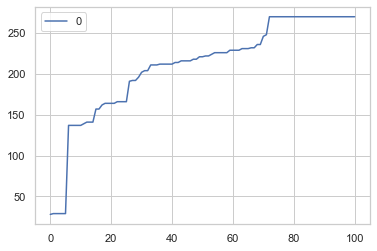

In [20]:
# get the missing curve
missing_list = []
for i in np.arange(0, 101, 1):
    missing = train.shape[1] - len(list(missing_values.index[missing_values['% of Total Values'] > i]))
    missing_list.append(missing)
pd.DataFrame(missing_list).plot()

In [21]:
len(list(missing_values.index[missing_values['% of Total Values'] > 90]))

0

## Train, Test split

SK_ID_CURR is now the index and we build a separated target y_ df from the training data X_. <br/>
Note that we have to build it in a DataFrame format (in order to extract a sample after the train-test split.

In [35]:
def preprocess_split(
    data=train,
    split_size=0.2,
    impute_strategy='mean',
    scale_strategy=False
):
    '''function that split data into train and test according to split_size (test)
    and impute missing values according to the impute strategy
    and option to MinMaxScale features'''
    # drop the target from the training data
    if 'TARGET' in data:
        X_ = data.drop(columns=['TARGET'])
    else:
        X_ = data.copy()
    y_ = data['TARGET']
    # to keep df format : store columns & index
    columns = X_.columns
    index = X_.index
    # imputation of missing values
    imputer = SimpleImputer(
        missing_values=np.nan,
        strategy=impute_strategy)
    imputer.fit(X_)
    X_ = pd.DataFrame(
        imputer.fit_transform(X_),
        columns=columns,
        index=index)
    # Scale if True, each feature to 0-1
    if scale_strategy is True:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(X_)
        X_ = pd.DataFrame(
            scaler.fit_transform(X_),
            columns=columns,
            index=index)
    # Split data into train and test set (stratify by target)
    X_train, X_test, y_train, y_test = train_test_split(
        X_,
        y_,
        stratify=y_,
        test_size=split_size,
        random_state=7)
    print('Training data shape: ', X_train.shape)
    print('Testing data shape: ', X_test.shape)
    print('Labels train data shape: ', y_train.shape)
    print('Labels test data shape: ', y_test.shape)
    return X_train, X_test, y_train, y_test, columns

In [36]:
X_train, X_test, y_train, y_test, features = preprocess_split()

Training data shape:  (246005, 269)
Testing data shape:  (61502, 269)
Labels train data shape:  (246005,)
Labels test data shape:  (61502,)


In [ ]:
X_train_sc, X_test_sc, y_train, y_test, features = preprocess_split(scale_strategy=True)

In [ ]:
X_train_me, X_test_me, y_train, y_test, features = preprocess_split(impute_strategy='mean')

In [ ]:
X_train_ms, X_test_ms, y_train, y_test, features = preprocess_split(impute_strategy='mean', scale_strategy=True)

### For code test only - Sampling - model selection process

In [ ]:
# randomly sample the train data and apply to target
X_train_sample = X_train.sample(n=24000, random_state=42)
# Get the indexes to sample target_vector
sample_index = X_train_sample.index
mask = (y_train.index.isin(sample_index))
y_train_sample = y_train[mask]
# print results
len(y_train_sample)

In [ ]:
X_train_re_sample = X_train_sample.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
# control failure rate of sample
print('global failure rate: ',
     round(100 * y_train_sample.value_counts()[1] / (y_train_sample.value_counts()[1] + y_train_sample.value_counts()[0]), 2))

In [ ]:
# randomly sample the test data and apply to target
X_test_sample = X_test.sample(n=6000, random_state=42)
# Get the indexes to sample target_vector
sample_index = X_test_sample.index
mask = (y_test.index.isin(sample_index))
y_test_sample = y_test[mask]
# print results
len(y_test_sample)

In [ ]:
# control failure rate of sample
print('global failure rate: ',
     round(100 * y_test_sample.value_counts()[1] / (y_test_sample.value_counts()[1] + y_test_sample.value_counts()[0]), 2))

In [ ]:
X_test_re_sample = X_test_sample.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
X_opt = X_train_re_sample
y_opt = y_train_sample
X_topt = X_test_re_sample
y_topt = y_test_sample

# Model evaluation

## Metric: Area Under Roc & "Damage Scoring"

First off all, accuracy (Σ True positive or negative / Σ Total) is __not a relevant metric__ in our case, mainly due to the __class imbalance__, with over than 90% accuracy if we predict the majority class only, granting loan to anyone and facing any risky clients failures.
The area under the ROC curve offers a more valuable metric, that can be trusted for models comparison. A model that simply guesses at random will have an ROC AUC of 0.5. Any improvement of AUC score, up to ideal 1, means the model gets to a minimal False positive rate and a maximal True positive rate.
In our case, we'll even discuss the opportunity of building our own score, based on an detailed interpretation of the confusion matrix (see [F-score](https://en.wikipedia.org/wiki/F-score)) to more accurately define what could be the "best" retuls, in terms of the financial opportunity or damages for the company. This lead to build a compromise between approval of risky clients and rejection og good ones. <br/>
After studying the resulting populated confusion matrix, we decided to use Fbeta to value the relative importance of recall over precision (with illustratives value of beta= 3 or 7), which is a good approach to value the financial damage of granting a loan to a failure-risky client than rejecting a loan to a "good" client.

## Classifiers evaluation techniques

1. first run and compare: to assess preprocessing techniques

3. Hyperopt [hyperopt](https://github.com/hyperopt/hyperopt) to find the most relevant model and its gest hyperparameters : alternate scoring (loss functions) tested.

3. restrain input (remove unimportant features) and best fit with cross validation technique.

## Classifiers rough training

Let's create a model_run function that will instanciate any classifier and get results.

In [61]:
def model_run(
    model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    f7 = fbeta_score(y_test, y_pred, beta=7)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    auc_score_roc = roc_auc_score(y_test, y_pred)

    print(model)
    print('AUC score: ', round(auc_score, 4))
    print('AUC score -roc: ', round(auc_score_roc, 4))
    print('Fbeta score (7): ', round(f7, 4))

    return fpr, tpr, auc_score, f7

### Naive Baseline

For a naive baseline, we could guess the same value for all examples on the testing set.  We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This  will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5.

In [28]:
naive = GaussianNB()

In [ ]:
fpr_naive, tpr_naive, auc_score_naive, f7_naive = model_run(naive)

In [ ]:
fpr_naive_me, tpr_naive_me, auc_score_naive_me, f7_naive_me = model_run(
    naive,
    X_train=X_train_me,
    y_train=y_train,
    X_test=X_test_me,
    y_test=y_test)

In [ ]:
fpr_naive_sc, tpr_naive_sc, auc_score_naive_sc, f7_naive_sc = model_run(
    naive,
    X_train=X_train_sc,
    y_train=y_train,
    X_test=X_test_sc,
    y_test=y_test)

In [ ]:
fpr_naive_ms, tpr_naive_ms, auc_score_naive_ms, f7_naive_ms = model_run(
    naive,
    X_train=X_train_ms,
    y_train=y_train,
    X_test=X_test_ms,
    y_test=y_test)

### Logistic Regression

In [29]:
logreg = LogisticRegression()

In [ ]:
fpr_logreg, tpr_logreg, auc_score_logreg, f7_logreg = model_run(logreg)

In [ ]:
fpr_logreg_me, tpr_logreg_me, auc_score_logreg_me, f7_logreg_me = model_run(
    logreg,
    X_train=X_train_me,
    y_train=y_train,
    X_test=X_test_me,
    y_test=y_test)

In [ ]:
fpr_logreg_sc, tpr_logreg_sc, auc_score_logreg_sc, f7_logreg_sc = model_run(
    logreg,
    X_train=X_train_sc,
    y_train=y_train,
    X_test=X_test_sc,
    y_test=y_test)

In [ ]:
fpr_logreg_ms, tpr_logreg_ms, auc_score_logreg_ms, f7_logreg_ms = model_run(
    logreg,
    X_train=X_train_ms,
    y_train=y_train,
    X_test=X_test_ms,
    y_test=y_test)

### Random Forest

In [30]:
rndfor = RandomForestClassifier()

In [ ]:
fpr_rndfor, tpr_rndfor, auc_score_rndfor, f7_rndfor = model_run(rndfor)

In [ ]:
fpr_rndfor_me, tpr_rndfor_me, auc_score_rndfor_me, f7_rndfor_me = model_run(
    rndfor,
    X_train=X_train_me,
    y_train=y_train,
    X_test=X_test_me,
    y_test=y_test)

In [ ]:
fpr_rndfor_sc, tpr_rndfor_sc, auc_score_rndfor_sc, f7_rndfor_sc = model_run(
    rndfor,
    X_train=X_train_sc,
    y_train=y_train,
    X_test=X_test_sc,
    y_test=y_test)

In [ ]:
fpr_rndfor_ms, tpr_rndfor_ms, auc_score_rndfor_ms, f7_rndfor_ms = model_run(
    rndfor,
    X_train=X_train_ms,
    y_train=y_train,
    X_test=X_test_ms,
    y_test=y_test)

### LightGBM

In [37]:
# features format
X_train_re = X_train.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_test_re = X_test.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [31]:
liggbm = LGBMClassifier()

In [ ]:
fpr_liggbm, tpr_liggbm, auc_score_liggbm, f7_liggbm = model_run(
    liggbm,
    X_train_re,
    y_train,
    X_test_re,
    y_test)

In [ ]:
# features format
X_train_re_me = X_train_me.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_test_re_me = X_test_me.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
liggbm = LGBMClassifier()
fpr_liggbm_me, tpr_liggbm_me, auc_score_liggbm_me, f7_liggbm_me = model_run(
    liggbm,
    X_train_re_me,
    y_train,
    X_test_re_me,
    y_test)

In [ ]:
# features format
X_train_re_sc = X_train_sc.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_test_re_sc = X_test_sc.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
liggbm = LGBMClassifier()
fpr_liggbm_sc, tpr_liggbm_sc, auc_score_liggbm_sc, f7_liggbm_sc = model_run(
    liggbm,
    X_train_re_sc,
    y_train,
    X_test_re_sc,
    y_test)

In [ ]:
# features format
X_train_re_ms = X_train_ms.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_test_re_ms = X_test_ms.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
liggbm = LGBMClassifier()
fpr_liggbm_ms, tpr_liggbm_ms, auc_score_liggbm_ms, f7_liggbm_ms = model_run(
    liggbm,
    X_train_re_ms,
    y_train,
    X_test_re_ms,
    y_test)

### Collect results : comparison preprocessing - classifiers

In [ ]:
# Collect results
preprocess_cases = [
    'Zero\n NotScaled',
    'Mean\n NotScaled',
    'Zero\n Scaled',
    'Mean\n Scaled']
NB_auc_scores = [
    auc_score_naive,
    auc_score_naive_me,
    auc_score_naive_sc,
    auc_score_naive_ms]
LR_auc_scores = [
    auc_score_logreg,
    auc_score_logreg_me,
    auc_score_logreg_sc,
    auc_score_logreg_ms]
RF_auc_scores = [
    auc_score_rndfor,
    auc_score_rndfor_me,
    auc_score_rndfor_sc,
    auc_score_rndfor_ms]
LG_auc_scores = [
    auc_score_liggbm,
    auc_score_liggbm_me,
    auc_score_liggbm_sc,
    auc_score_liggbm_ms]

In [ ]:
# display results
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Preprocessing effect')
sns.barplot(ax=axes[0, 0], x=preprocess_cases, y=NB_auc_scores, palette="Blues")
axes[0, 0].set_title('Gaussian Naive Bayes')
sns.barplot(ax=axes[0, 1], x=preprocess_cases, y=LR_auc_scores, palette="Oranges")
axes[0, 1].set_title('Logistic Regression')
sns.barplot(ax=axes[1, 0], x=preprocess_cases, y=RF_auc_scores, palette="Greens")
axes[1, 0].set_title('Random Forest')
sns.barplot(ax=axes[1, 1], x=preprocess_cases, y=LG_auc_scores, palette="Reds")
axes[1, 1].set_title('Light GBM')

### Roc curves (case of preprocessing mean-scaled)

In [ ]:
# for Roc curve plots
classifier_names = [
    'Best Gaussian Naive Bayes',
    'Best Logistic Regression',
    'Best Random Forest',
    'Best LightGBM']

In [ ]:
# display roc curves
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.plot(
    fpr_naive_ms,
    tpr_naive_ms,
    label=str(classifier_names[0])
    + ' AUC: '
    + str(round(auc_score_naive_ms, 3)))
ax.plot(
    fpr_logreg_ms,
    tpr_logreg_ms,
    label=str(classifier_names[1])
    + ' AUC: '
    + str(round(auc_score_logreg_ms, 3)))
ax.plot(
    fpr_rndfor_me,
    tpr_rndfor_me,
    label=str(classifier_names[2])
    + ' AUC: '
    + str(round(auc_score_rndfor_me, 3)))
ax.plot(
    fpr_liggbm,
    tpr_liggbm,
    label=str(classifier_names[3])
    + ' AUC: '
    + str(round(auc_score_liggbm, 3)))
ax.plot([0, 1], [0, 1], linewidth=2, linestyle='--')
plt.legend(loc="best")
plt.title("Classifiers ROC curves & AUC values")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

### Oversampling with SMOTE to remedy  class imbalance

This is a Synthetic Minority Oversampling Technique which consists in creating data to enrich the minority class. <br/>
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
# observe class imbalance
pd.Series(y_train).value_counts().plot.bar()

In [ ]:
# initialiaze SMOTE
sm = SMOTE(random_state=7)

In [ ]:
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())

In [ ]:
# observe that data has been balanced
pd.Series(y_train_sm).value_counts().plot.bar()

### Comparison SMOTE versus class_weight='balanced'

In [ ]:
fpr_logreg_sm, tpr_logreg_sm, auc_score_logreg_sm, f7_logreg_sm = model_run(
    logreg,
    X_train=X_train_sm,
    y_train=y_train_sm,
    X_test=X_test,
    y_test=y_test)

In [ ]:
log_reg_w = LogisticRegression(class_weight='balanced')

In [ ]:
fpr_logreg_w, tpr_logreg_w, auc_score_logreg_w, f7_logreg_w = model_run(
    log_reg_w,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test)

In [ ]:
fpr_logreg_w, tpr_logreg_w, auc_score_logreg_w, f7_logreg_w = model_run(
    log_reg_w,
    X_train=X_train_sm,
    y_train=y_train_sm,
    X_test=X_test,
    y_test=y_test)

In [ ]:
show_results(logreg, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, case='Log Reg - Raw')

In [ ]:
show_results(logreg, X_train=X_train_sm, X_test=X_test, y_train=y_train_sm, y_test=y_test, case='Log Reg with Smote')

In [ ]:
show_results(log_reg_w, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, case='Log Reg balanced')

In [ ]:
show_results(log_reg_w, X_train=X_train_sm, X_test=X_test, y_train=y_train_sm, y_test=y_test, case='Log Reg balanced & SMOTE')

In [ ]:
fpr_rndfor_sm, tpr_rndfor_sm, auc_score_rndfor_sm, f7_rndfor_sm = model_run(
    rndfor,
    X_train=X_train_sm,
    y_train=y_train_sm,
    X_test=X_test,
    y_test=y_test)

In [ ]:
rndfor_w = RandomForestClassifier(class_weight='balanced')

In [ ]:
fpr_rndfor_w, tpr_rndfor_w, auc_score_rndfor_w, f7_rndfor_w = model_run(
    rndfor_w,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test)

In [ ]:
fpr_rndfor_w_sm, tpr_rndfor_w_sm, auc_score_rndfor_w_sm, f7_rndfor_w_sm = model_run(
    rndfor_w,
    X_train=X_train_sm,
    y_train=y_train_sm,
    X_test=X_test,
    y_test=y_test)

In [ ]:
# features format
X_train_re_sm = X_train_sm.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
fpr_liggbm_sm, tpr_liggbm_sm, auc_score_liggbm_sm, f7_liggbm_sm = model_run(
    liggbm,
    X_train_re_sm,
    y_train_sm,
    X_test_re,
    y_test)

In [ ]:
liggbm_w = LGBMClassifier(class_weight='balanced')
fpr_liggbm_w, tpr_liggbm_w, auc_score_liggbm_w, f7_liggbm_w = model_run(
    liggbm_w,
    X_train_re,
    y_train,
    X_test_re,
    y_test)

In [ ]:
fpr_liggbm_w_sm, tpr_liggbm_w_sm, auc_score_liggbm_w_sm, f7_liggbm_w_sm = model_run(
    liggbm_w,
    X_train_re_sm,
    y_train_sm,
    X_test_re,
    y_test)

In [ ]:
show_results(liggbm, X_train=X_train_re, X_test=X_test_re, y_train=y_train, y_test=y_test, case='Light GBM - Raw')

In [ ]:
show_results(liggbm_w, X_train=X_train_re, X_test=X_test_re, y_train=y_train, y_test=y_test, case='Light GBM with balanced class_weight')

In [ ]:
show_results(liggbm_w, X_train=X_train_re_sm, X_test=X_test_re, y_train=y_train_sm, y_test=y_test, case='Light GBM balanced class_weight & SMOTE')

In [ ]:
show_results(liggbm, X_train=X_train_re_sm, X_test=X_test_re, y_train=y_train_sm, y_test=y_test, case='Light GBM SMOTE')

## Optimization

Each classifier comes with its own set of hyperparameters, and those first rough results are worthless because default parameters may be wrong in our case.

### initialiaze search space

In [46]:
# Initializing the search space
space = {}

### preprocessing

here we could evaluate how preprocessing steps affect the results.

### models parameters

In [47]:
models_spaces = {}

In [32]:
naive.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [33]:
models_spaces['naive'] = {
    'model': GaussianNB
}

In [34]:
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [35]:
models_spaces['logreg'] = {
    'model': LogisticRegression,
    'C': hp.uniform('logreg_C', 0.0001, 2),
    'class_weight': hp.choice('logreg_class_weight', ['balanced', None]),
    'tol': hp.uniform('logreg_tol', 0.00001, 0.0001),
    'solver': hp.choice('logreg_solver', ['newton-cg', 'lbfgs', 'liblinear']),
    'max_iter': hp.choice('logreg_max_iter', range(100, 1000)),
    # 'n_jobs': '-1'
} 

9:2: W291 trailing whitespace


In [36]:
rndfor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [37]:
models_spaces['rndfor'] = {
    'model': RandomForestClassifier,
    'class_weight': hp.choice('rndfor_class_weight', ['balanced', None]),
    'max_depth': hp.choice('rndfor_max_depth', np.arange(1, 30, dtype=int)),
    'max_features': hp.choice('rndfor_max_features', range(1, 3)),
    'n_estimators': hp.choice('rndfor_n_estimators', np.arange(10, 800, 50, dtype=int)),
    'criterion': hp.choice('rndfor_criterion', ["gini", "entropy"])
}

6:80: E501 line too long (88 > 79 characters)


In [38]:
liggbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [39]:
models_spaces['liggbm'] = {
    'model': LGBMClassifier,
    'n_estimators': hp.choice('liggbm_n_estimators', np.arange(10, 810, 50, dtype=int)),
    'class_weight': hp.choice('liggbm_class_weight', ['balanced', None]),
    'max_depth': hp.choice('liggbm_max_depth', np.arange(1, 30, dtype=int)),
    'num_leaves': hp.choice('liggbm_num_leaves', np.arange(4, 101, 4, dtype=int)),
    'boosting_type': hp.choice('liggbm_boosting_type', ['gbdt', 'dart', 'goss']),
    'learning_rate': hp.loguniform('liggbm_learning_rate', np.log(0.01), np.log(0.2))
}

3:80: E501 line too long (88 > 79 characters)
6:80: E501 line too long (82 > 79 characters)
7:80: E501 line too long (81 > 79 characters)
8:80: E501 line too long (85 > 79 characters)


### Search space

In [48]:
# choice of a model into collection of models_spaces
space['models_spaces'] = hp.choice(
        'models_spaces',
        [models_spaces[key] for key in models_spaces]
    )

### Tree Parzen Estimator algorithm

In [38]:
# Create the Tree Parzen Estimator algorithm
tpe_algorithm = tpe.suggest

### Initiate KFold

In [39]:
# initiate Kfold
skf = StratifiedKFold(n_splits=5)

### Objective function
As a first step, we tried to define FBeta (7) as the general objective, this lead to erroneous Naive model selection, and the general preformance of the model can be under our expectations : we could demonstrate that an higher AUC Score performance enable even a better FBeta score, setting the right threshold value. We'll focus only on AUC Score.

In [40]:
# Define th objective function
def obj_fnc(
    params,
    X_=X_train_re,
    y_=y_train
):
    # display the set of parameters currently evaluated
    print('current params:', params)
    # get all parameters, except the model
    parameters = params['models_spaces'].copy()
    del parameters['model']
    # create the classifier & its parameters
    clf = params['models_spaces']['model'](**parameters)
    # Perform n_folds cross validation
    start = timer()
    print('Cross-val predict in progress…')
    y_pred_proba = cross_val_predict(
        clf,
        X_,
        y_,
        method='predict_proba',
        cv=skf)[:, 1]
    # Compute score
    fpr, tpr, _ = roc_curve(y_, y_pred_proba)
    score = auc(fpr, tpr)
    # return loss and status
    loss = 1 - score
    run_time = timer() - start
    # displays results
    print("Loss of the model:", loss)
    # evaluation dict
    dict_eval = {
        'loss': loss,
        'score': score,
        'run_time': run_time,
        'status': STATUS_OK,
    }
    return dict_eval

In [41]:
def run_trials():
    trials_step = 1  # nb add trials after loading (1: save after iteration)
    initial_evals = 1  # initial max_trials.
    try:  # try to load an already saved trials object, and increase the max
        hypopt_trials = pickle.load(open("hp_trials/trials.hyperopt", "rb"))
        print("Found saved Trials! Loading...")
        max_evals = len(hypopt_trials.trials) + trials_step
        print("Rerunning from {} trials.".format(len(hypopt_trials.trials)))
    except:  # create a new trials object and start searching
        print("Unable to load previous trials...")
        hypopt_trials = Trials()
        max_evals = initial_evals
    # Optimisation accross the search space
    global best_params
    best_params = fmin(
        obj_fnc,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=hypopt_trials
    )
    # save the trials object
    with open("hp_trials/trials.hyperopt", mode="wb") as f:
        pickle.dump(hypopt_trials, f)
    # get the best_params and save them
    best_params = space_eval(space, best_params)
    with open("hp_trials/best_params.hyperopt", mode="wb") as f:
        pickle.dump(best_params, f)
    # print the main results
    print("\nBest loss:", hypopt_trials.best_trial['result']['loss'],
          "\n----------------------")

### Perform "hyperopt"

Here we launch a persistant search, keeping an eye on the Best loss evolution. For further use, a stop point could be implemented, for instance if Best loss does not change for a given number of iterations.

In [ ]:
keep_going = True


def key_capture_thread():
    global keep_going
    # blocks until pressing 'Esc'.
    keyboard.wait('esc')
    keep_going = False
    print('\nINTERRUPTING… Please wait until shut down.')


def trials_loop():
    th.Thread(target=key_capture_thread, args=(), name='key_capture_thread', daemon=True).start()
    while keep_going:
        print("\nRUNNING... Press 'ESC' key to interrupt.")
        # launch hyperopt
        run_trials()
    print('\nINTERRUPTED!')


trials_loop()

### Search space : focusing LGBM

In [49]:
models_spaces = {}

In [50]:
models_spaces['liggbm'] = {
    'model': LGBMClassifier,
    'n_estimators': hp.choice('liggbm_n_estimators', np.arange(10, 810, 50, dtype=int)),
    'class_weight': hp.choice('liggbm_class_weight', ['balanced']),
    'max_depth': hp.choice('liggbm_max_depth', np.arange(1, 30, dtype=int)),
    'num_leaves': hp.choice('liggbm_num_leaves', np.arange(4, 101, 4, dtype=int)),
    'boosting_type': hp.choice('liggbm_boosting_type', ['gbdt', 'dart', 'goss']),
    'learning_rate': hp.loguniform('liggbm_learning_rate', np.log(0.01), np.log(0.2))
}

In [51]:
# choice of a model into collection of models_spaces
space['models_spaces'] = hp.choice(
        'models_spaces',
        [models_spaces[key] for key in models_spaces]
    )

### Perform hyperopt

In [ ]:
keep_going = True


def key_capture_thread():
    global keep_going
    # blocks until pressing 'Esc'.
    keyboard.wait('esc')
    keep_going = False
    print('\nINTERRUPTING… Please wait until shut down.')


def trials_loop():
    th.Thread(target=key_capture_thread, args=(), name='key_capture_thread', daemon=True).start()
    while keep_going:
        print("\nRUNNING... Press 'ESC' key to interrupt.")
        # launch hyperopt
        run_trials_auc()
    print('\nINTERRUPTED!')


trials_loop()

## Best Model training

### Get model params

In [74]:
# Load the best_params
best_params = pickle.load(open("hp_trials/saved_best_params.hyperopt", "rb"))

# print current best_params
best_params

{'models_spaces': {'boosting_type': 'goss',
  'class_weight': None,
  'learning_rate': 0.01897824986309232,
  'max_depth': 23,
  'model': lightgbm.sklearn.LGBMClassifier,
  'n_estimators': 610,
  'num_leaves': 52}}

In [64]:
def define_model(params):
    # Get the model from parameters
    model = params['models_spaces'].pop('model')

    # Instanciate model with best parameters
    model_instance = model(**params['models_spaces'])

    # Return instanciated model
    return model_instance

In [65]:
best_model = define_model(best_params)

In [66]:
best_model.get_params

<bound method LGBMModel.get_params of LGBMClassifier(boosting_type='goss', learning_rate=0.01897824986309232,
               max_depth=23, n_estimators=610, num_leaves=52)>

In [68]:
best_model.set_params(class_weight= 'balanced')

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               learning_rate=0.01897824986309232, max_depth=23,
               n_estimators=610, num_leaves=52)

In [69]:
fpr_best, tpr_best, auc_score_best, f7_best = model_run(
    best_model,
    X_train_re,
    y_train,
    X_test_re,
    y_test)

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               learning_rate=0.01897824986309232, max_depth=23,
               n_estimators=610, num_leaves=52)
AUC score:  0.7646
AUC score -roc:  0.6929
Fbeta score (7):  0.6118


### Overview of features importance

In [127]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [71]:
feature_importance_values = best_model.feature_importances_

In [72]:
feature_names = list(X_train.columns)

In [73]:
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

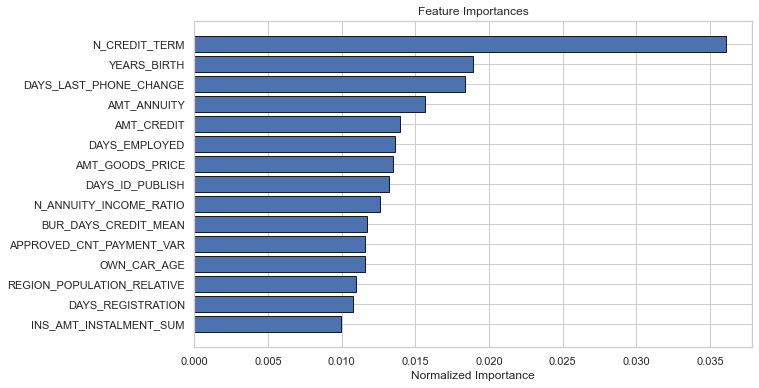

In [74]:
# Show the feature importances for the new features
feature_importances_sorted = plot_feature_importances(feature_importances)

In [86]:
feature_importances_sorted['cum_importance'] = feature_importances_sorted['importance_normalized'].cumsum()

<AxesSubplot:>

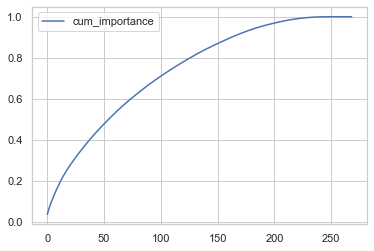

In [99]:
feature_importances_sorted.plot(y=['cum_importance'], grid=True)

In [115]:
most_important_features = feature_importances_sorted[feature_importances_sorted['importance'] > 99].feature.tolist()

In [116]:
most_important_features.insert(0, 'TARGET')

In [117]:
most_important_features.insert(0, 'SK_ID_CURR')

In [119]:
# reload target and cut any_applications dataset
with open("Data/sel_app_mean.pkl", mode="rb") as df:
    any_application = pickle.load(df)

In [120]:
any_application.head(1)

,SK_ID_CURR,TARGET,CODE_GENDER,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,LIVINGAREA_AVG,BASEMENTAREA_MODE,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,TOTALAREA_MODE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,N_CNT_PREV_REJECTED_HC,N_CNT_PREV_REJECTED_SCOFR,N_FLAG_REJECTED,N_ADJ_REJECT_RECENCY_INDEX,N_REJECT_RATE,N_BUR_LAST_APPLICATION,YEARS_BIRTH,N_DAYS_EMPLOYED_RATIO,N_CREDIT_INCOME_RATIO,N_ANNUITY_INCOME_RATIO,N_CREDIT_TERM,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Pensioner,BUR_DAYS_CREDIT_MIN,BUR_DAYS_CREDIT_MAX,BUR_DAYS_CREDIT_MEAN,BUR_DAYS_CREDIT_VAR,BUR_DAYS_CREDIT_ENDDATE_MIN,BUR_DAYS_CREDIT_ENDDATE_MAX,BUR_DAYS_CREDIT_ENDDATE_MEAN,BUR_AMT_CREDIT_MAX_OVERDUE_MAX,BUR_AMT_CREDIT_MAX_OVERDUE_MEAN,BUR_AMT_CREDIT_MAX_OVERDUE_SUM,BUR_AMT_CREDIT_SUM_MAX,BUR_AMT_CREDIT_SUM_MEAN,BUR_AMT_CREDIT_SUM_SUM,BUR_AMT_CREDIT_SUM_DEBT_MAX,BUR_AMT_CREDIT_SUM_DEBT_MEAN,BUR_AMT_CREDIT_SUM_DEBT_SUM,BUR_AMT_CREDIT_SUM_LIMIT_MAX,BUR_AMT_CREDIT_SUM_LIMIT_MEAN,BUR_AMT_CREDIT_SUM_LIMIT_SUM,BUR_MONTHS_BALANCE_SIZE_MEAN,BUR_N_BUR_START_OBSERVED_MEAN,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MIN,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MAX,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MEAN,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_SUM,BUR_N_BUR_AMT_CREDIT_DEBT_RATE_VAR,BUR_CREDIT_ACTIVE_Active_MEAN,BUR_CREDIT_ACTIVE_Closed_MEAN,BUR_CREDIT_TYPE_Cash loans_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MAX,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_SUM,ACTIVE_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_MIN,ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_MAX,ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_MEAN,ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_SUM,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_VAR,CLOSED_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_CREDIT_DAY_OVERDUE_MAX,CLOSED_CREDIT_DAY_OVERDUE_MEAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_MAX,CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_SUM,CLOSED_AMT_CREDIT_SUM_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MAX,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM,CLOSED_AMT_CREDIT_SUM_LIMIT_MAX,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_SUM,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_MIN,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_MAX,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_MEAN,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_SUM,CLOSED_N_BUR_EARLINESS_OVERDUE_RATIO_VAR,CLOSED_N_BUR_AMT_CREDIT_DEBT_RATE_MIN,CLOSED_N_BUR_AMT_CREDIT_DEBT_RATE_MAX,CLOSED_N_BUR_AMT_CREDIT_DEBT_RATE_MEAN,CLOSED_N_BUR_AMT_CREDIT_DEBT_RATE_SUM,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_N_APP_CREDIT_RATIO_MIN,PREV_N_APP_CREDIT_RATIO_MAX,PREV_N_APP_CREDIT_RATIO_MEAN,PREV_N_ADJ_CREDIT_RATIO_MIN,PREV_N_ADJ_CREDIT_RATIO_MAX,PREV_N_ADJ_CREDIT_RATIO_MEAN,PREV_N_ADJ_INTEREST_EVAL_MIN,PREV_N_ADJ_INTEREST_EVAL_MAX,PREV_N_ADJ_INTEREST_EVAL_MEAN,PREV_N_CREDIT_PROLONG_RATIO_VAR,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_DAYS_DECISION_MIN,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_VAR,PREV_NC_LOAN_TERM_SUM,PREV_NC_LOAN_AGE_MAX,PREV_NC_LOAN_AGE_SUM,PREV_NAME_CONTRACT_TY

In [386]:
any_application.shape

(356251, 271)

In [385]:
any_application_cut = any_application.filter(most_important_features)

In [387]:
any_application_cut.shape

(356251, 128)

In [ ]:
# save the data 
filename = 'Data/sel_app_cut.pkl'
pickle.dump(any_application_cut, open(filename, 'wb'))

### Get back train - test from "Any applications Cut"

In [62]:
# load train
with open("Data/sel_app_cut.pkl", mode="rb") as df:
    any_application_cut = pickle.load(df)
print('New applications full shape: ', any_application_cut.shape)

New applications full shape:  (356251, 128)


In [63]:
# keep training applications only
train = any_application_cut[any_application_cut['TARGET'].notna()]
new = any_application_cut[any_application_cut['TARGET'].isna()]

In [64]:
print('Training set full shape: ', train.shape)
print('New application set full shape: ', new.shape)

Training set full shape:  (307507, 128)
New application set full shape:  (48744, 128)


In [65]:
# set index with SK_ID_CURR
train = train.set_index('SK_ID_CURR')
new = new.set_index('SK_ID_CURR')

In [66]:
X_ = train.drop(columns=['TARGET'])
new = new.drop(columns=['TARGET'])
y_ = train['TARGET']

In [67]:
X_.fillna(0, inplace=True)
new.fillna(0, inplace=True)

In [71]:
# Creating fetature list and categorical feature list
feature_names = X_.columns.values.tolist()
categorical_features=[]
for i, cat in enumerate(feature_names):
    if train[cat].nunique() == 2:
        categorical_features.append(i)
#Creating dict with possible value for cat features.
categorical_names = {}
for feature in categorical_features:
    categorical_names[feature] = np.array([0,1])

In [78]:
categorical_features

[17, 60, 71]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X_,
    y_,
    stratify=y_,
    test_size=0.2,
    random_state=42)
print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)
print('Labels train data shape: ', y_train.shape)
print('Labels test data shape: ', y_test.shape)

Training data shape:  (246005, 126)
Testing data shape:  (61502, 126)
Labels train data shape:  (246005,)
Labels test data shape:  (61502,)


In [79]:
# features format
X_train_re = X_train.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_test_re = X_test.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [106]:
custom_model = LGBMClassifier(
    boosting_type='goss',
    class_weight='balanced',
    learning_rate=0.02,
    num_leaves=5,
    max_depth=8,
    n_estimators=200)

In [107]:
custom_model.fit(X_train_re,
                 y_train,
                 eval_set=(X_test_re, y_test),
                 categorical_feature=categorical_features,
                 verbose=50)

[50]	valid_0's binary_logloss: 0.660891
[100]	valid_0's binary_logloss: 0.642608
[150]	valid_0's binary_logloss: 0.63
[200]	valid_0's binary_logloss: 0.620806


LGBMClassifier(boosting_type='goss', class_weight='balanced',
               learning_rate=0.02, max_depth=8, n_estimators=200, num_leaves=5)

In [108]:
y_pred = custom_model.predict(X_test)
y_pred_proba = custom_model.predict_proba(X_test)[:, 1]
f7 = fbeta_score(y_test, y_pred, beta=7)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = auc(fpr, tpr)
auc_score_roc = roc_auc_score(y_test, y_pred)

In [109]:
pred_good = (y_pred == 0).sum()
pred_fail = (y_pred == 1).sum()
print(pred_fail / (pred_good + pred_fail))

0.3630613638580859


In [110]:
print(custom_model)
print('AUC score: ', round(auc_score, 4))
print('AUC score -roc: ', round(auc_score_roc, 4))
print('Fbeta score (7): ', round(f7, 4))

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               learning_rate=0.02, max_depth=8, n_estimators=200, num_leaves=5)
AUC score:  0.7333
AUC score -roc:  0.67
Fbeta score (7):  0.6314


In [132]:
class_names = ['0: Low Risk','1: Failure Risk']

In [133]:
# Initialize Lime explainer
explainer = LimeTabularExplainer(
    training_data=X_.values,
    feature_names=X_.columns,
    mode='classification',
    training_labels=y_,
    class_names=class_names,
    categorical_features=categorical_features,
    categorical_names=categorical_names,
    discretize_continuous=False)

In [134]:
def explanation(i):
    exp = explainer.explain_instance(
        X_.loc[i].values,
        custom_model.predict_proba,
        num_features=10)
    exp.show_in_notebook(show_table=True)
    return exp

In [135]:
test_exp = explanation(357599)

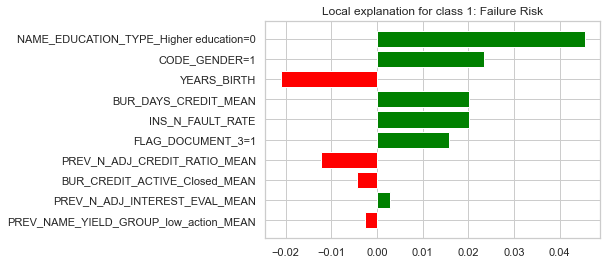

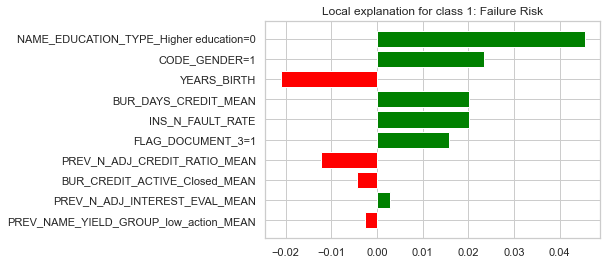

In [136]:
test_exp.as_pyplot_figure()

In [128]:
feature_importance_values = custom_model.feature_importances_

In [129]:
feature_names = list(X_train.columns)

In [130]:
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

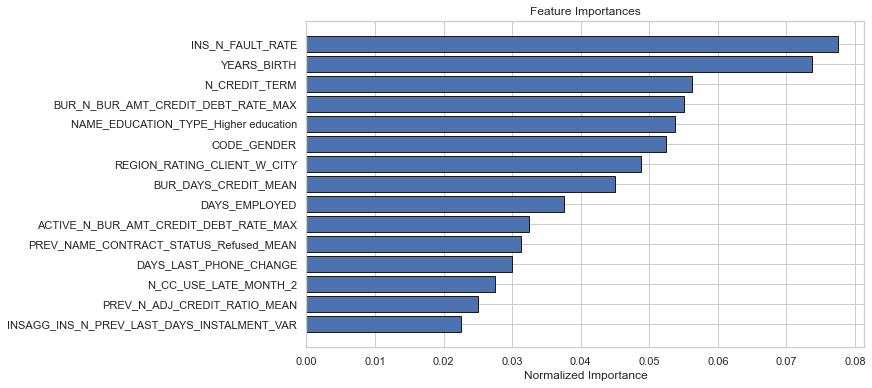

In [131]:
# Show the feature importances for the new features
feature_importances_sorted = plot_feature_importances(feature_importances)

## Introduce threshold

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [142]:
# define a function to make threshold adjustable
def threshold_pred(model, X, threshold=0.1):
    pred = model.predict_proba(X)
    y_pred = pred[:, 1] > threshold
    return pred, y_pred.astype(int)

In [143]:
# get the predict_proba from a model
def get_predict_proba(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    cols=None
):
    model.fit(X_train[cols], y_train)
    y_pred_proba = model.predict_proba(X_test[cols])[:, 1]
    return y_pred_proba

In [166]:
def fbeta_threshold(y_pred_proba, y_test, threshold=0.5, beta=7):
    y_pred = y_pred_proba > threshold
    fbeta_th = fbeta_score(y_test, y_pred, beta=beta)
    pred_good = (y_pred == 0).sum()
    pred_fail = (y_pred == 1).sum()
    f_rate = pred_fail / (pred_good + pred_fail)
    return fbeta_th, f_rate

In [150]:
y_best_proba = get_predict_proba(
    best_model,
    X_train_re,
    y_train,
    X_test_re,
    y_test,
    cols=X_train_re.columns
)

In [168]:
f7_th_best, f_rate_7_best = fbeta_threshold(y_best_proba, y_test)
print('Fbeta score (7), case best, threshold=0.5 : ', round(f7_th_best, 4))
print('Failure rate, threshold=0.5 : ', round(f_rate_7_best, 4))

Fbeta score (7), case best, threshold=0.5 :  0.6105
Failure rate, threshold=0.5 :  0.2895


In [169]:
f3_th_best, f_rate_3_best = fbeta_threshold(y_best_proba, y_test, beta=3)
print('Fbeta score (3), case best, threshold=0.5 : ', round(f3_th_best, 4))
print('Failure rate, threshold=0.5 : ', round(f_rate_3_best, 4))

Fbeta score (3), case best, threshold=0.5 :  0.5102
Failure rate, threshold=0.5 :  0.2895


#### adjust threshold

In [170]:
# with beta = 7
scores = []
f_rates = []
for i in np.linspace(0, 1, num=101):
    score, f_rate = fbeta_threshold(y_best_proba, y_test, threshold=i)
    scores.append(score)
    f_rates.append(f_rate)    

Max score: 0.8205388204921233
Optimal threshold: 0.13


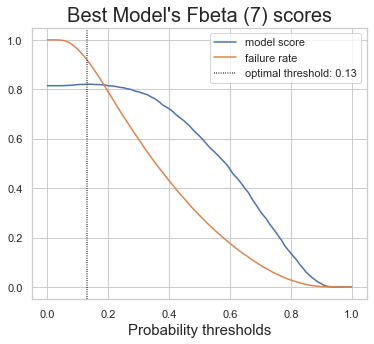

In [172]:
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(np.linspace(0, 1, num=101), scores, label="model score")
plt.plot(np.linspace(0, 1, num=101), f_rates, label="failure rate")
max_score = max(scores)
opt_threshold = np.linspace(0, 1, num=101)[scores.index(max_score)]

plt.axvline(x=opt_threshold, color='k', dashes=(0.5, 1), label="optimal threshold: {}".format(opt_threshold))

plt.title("Best Model's Fbeta (7) scores", fontsize=20)
plt.xlabel("Probability thresholds", fontsize=15)
plt.legend()

print("Max score:", max_score)
print("Optimal threshold:", opt_threshold)

In [176]:
# same with beta = 2
scores_ = []
f_rates_ = []
for i in np.linspace(0, 1, num=101):
    score_, f_rate_ = fbeta_threshold(y_best_proba, y_test, threshold=i, beta=2)
    scores_.append(score_)
    f_rates_.append(f_rate_)

Max score: 0.4263575563984828
Optimal threshold: 0.47


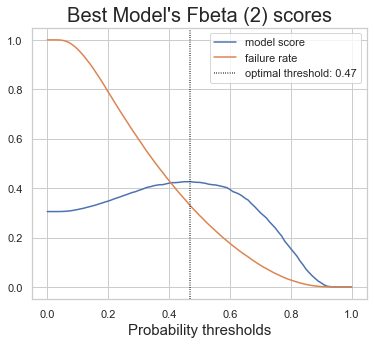

In [178]:
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(np.linspace(0, 1, num=101), scores_, label="model score")
plt.plot(np.linspace(0, 1, num=101), f_rates, label="failure rate")

max_score = max(scores_)
opt_threshold = round(np.linspace(0, 1, num=101)[scores_.index(max_score)], 2)

plt.axvline(x=opt_threshold, color='k', dashes=(0.5, 1), label="optimal threshold: {}".format(opt_threshold))

plt.title("Best Model's Fbeta (2) scores", fontsize=20)
plt.xlabel("Probability thresholds", fontsize=15)
plt.legend()

print("Max score:", max_score)
print("Optimal threshold:", opt_threshold)

# Overview of results

In [ ]:
# Collect results
classifier_names = [
    'Gaussian Naive Bayes',
    'Logistic Regression',
    'LogReg_Best',
    'Random Forest',
    'LightGBM',
    'LightGBM_CV']
auc_scores = [
    auc_score_naive,
    auc_score_logreg,
    auc_score_best,
    auc_score_rndfor,
    auc_score_liggbm,
    auc_score]
f7_scores = [
    f7_naive,
    f7_logreg,
    f7_best,
    f7_rndfor,
    f7_liggbm,
    f7]

In [ ]:
# display results
sns.set_color_codes("colorblind")
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.title('Classifiers scores: Area Under Roc Curve, Fbeta (7)')
s1 = sns.barplot(x=classifier_names, y=auc_scores)
s1.set_xticklabels(s1.get_xticklabels(), rotation=90)
plt.ylabel('AUC scores', fontsize=12)
plt.subplot(212)
s2 = sns.barplot(x=classifier_names, y=f7_scores)
s2.set_xticklabels(s2.get_xticklabels(), rotation=90)
plt.ylabel('Fbeta scores', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# display roc curves
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.plot(
    fpr_naive,
    tpr_naive,
    label=str(classifier_names[0])
    + ' AUC: '
    + str(round(auc_score_naive, 3)))
ax.plot(
    fpr_logreg,
    tpr_logreg,
    label=str(classifier_names[1])
    + ' AUC: '
    + str(round(auc_score_logreg, 3)))
ax.plot(
    fpr_best,
    tpr_best,
    label=str(classifier_names[2])
    + ' AUC: '
    + str(round(auc_score_best, 3)))
ax.plot(
    fpr_rndfor,
    tpr_rndfor,
    label=str(classifier_names[3])
    + ' AUC: '
    + str(round(auc_score_rndfor, 3)))
ax.plot(
    fpr_liggbm,
    tpr_liggbm,
    label=str(classifier_names[4])
    + ' AUC: '
    + str(round(auc_score_liggbm, 3)))
ax.plot(
    fpr,
    tpr,
    label=str(classifier_names[5])
    + ' AUC: '
    + str(round(auc_score, 3)))

ax.plot([0, 1], [0, 1], linewidth=2, linestyle='--')
plt.legend(loc="best")
plt.title("Classifiers ROC curves & AUC values")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Train & predict

In [400]:
# set index with SK_ID_CURR
any_application_cut = any_application_cut.set_index('SK_ID_CURR')

In [401]:
# impute by mean any missing value from original cutted dataframe
target = any_application_cut['TARGET']
any_application_impute = any_application_cut.drop(columns='TARGET')

In [404]:
# to keep df format : store columns & index
columns = any_application_impute.columns
index = any_application_impute.index
# imputation of missing values
imputer = SimpleImputer(
    missing_values=np.nan,
    strategy='mean')
imputer.fit(any_application_impute)
any_application_impute = pd.DataFrame(
    imputer.fit_transform(any_application_impute),
    columns=columns,
    index=index)

In [405]:
any_application_impute['TARGET'] = target

In [406]:
train = any_application_impute[any_application_impute['TARGET'].notna()]
test = any_application_impute[any_application_impute['TARGET'].isna()]

In [407]:
test.drop(columns=['TARGET'], inplace=True)

In [408]:
print('Training set full shape: ', train.shape)
print('Testing set full shape: ', test.shape)

Training set full shape:  (307507, 127)
Testing set full shape:  (48744, 126)


In [409]:
y_train = train['TARGET']

In [410]:
X_train = train.drop(columns='TARGET')

In [411]:
X_test = test

In [412]:
# control failure rate of train
print('global failure rate: ',
     round(100 * y_train.value_counts()[1] / (y_train.value_counts()[1] + y_train.value_counts()[0]), 2))

global failure rate:  8.07


In [413]:
best_model

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               learning_rate=0.01897824986309232, max_depth=23,
               n_estimators=610, num_leaves=52)

In [414]:
# features format
X_train = X_train.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [415]:
best_model.fit(X_train, y_train)

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               learning_rate=0.01897824986309232, max_depth=23,
               n_estimators=610, num_leaves=52)

In [416]:
y_proba = best_model.predict_proba(X_test)[:, 1]

In [417]:
y_proba

array([0.50172708, 0.71036158, 0.22155926, ..., 0.08137186, 0.29480859,
       0.63035566])

In [418]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [419]:
# labels for threshold = 0.5
y_pred = to_labels(y_proba, 0.5)

In [420]:
nb_good = (y_pred == 0).sum()
nb_failure = (y_pred == 1).sum()

In [421]:
# control failure rate of y_pred
print('global failure rate: ',
     round(100 * nb_failure / (nb_good + nb_failure), 2))

global failure rate:  27.69


This underestimate the real value of failure - meaning to many loans are refused

In [422]:
feature_importance_values = best_model.feature_importances_

In [423]:
feature_names = list(train.drop(columns='TARGET').columns)

In [424]:
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

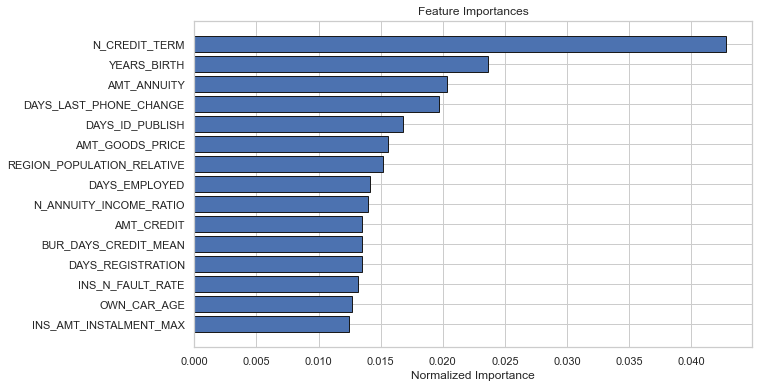

In [425]:
# Show the feature importances for the new features
feature_importances_sorted = plot_feature_importances(feature_importances)

In [426]:
best_model

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               learning_rate=0.01897824986309232, max_depth=23,
               n_estimators=610, num_leaves=52)

In [427]:
test.insert(0, column='RISK_PROBA', value=y_proba)

In [428]:
test.insert(0, column='RISK_FLAG', value=y_pred)

In [429]:
# save the model to disk
filename = 'Data/model.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [430]:
# save the results
filename = 'Data/final.pkl'
pickle.dump(test, open(filename, 'wb'))

In [431]:
test.shape

(48744, 128)